# Song Generation: Neural Style Transfer for audio

With the use of convolutional neural networks (CNNs), we saw a vast rise in works involving style transfer to create a new image involving the content from one image and the style from a different image. In this project, we will be investigating applications and usage of CNNs in generating audios from random noise containing the content (i.e. tempo, melody) of one audio clip and the style of another audio (i.e. instrument types, pitch). The solution to this problem can potentially allow generation of new audio through the mixture of two completely different types of audio content.

## Import libraries

In [1]:
import sys
import numpy as np
import tensorflow as tf
import librosa
from pydub import AudioSegment
import os
from IPython.display import Audio, display
import matplotlib.pyplot as plt
from sys import stderr
%matplotlib inline

/Users/williampark73/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Hyperparameters

In [2]:
CONTENT_FILENAME = "inputs/bensound-ukulele"
STYLE_FILENAME = "inputs/fire"
OUTPUT_FILENAME = "out_ukelele_fire"
extension = ".mp3" #".wav" #in case browser does not play .wav e.g. mozilla firefox
FFT_WINDOW_SIZE = 2048 #default n_fft in librosa 
HOP_LENGTH = int(FFT_WINDOW_SIZE/4) #default -- change this to regulate output length for fixed n_fft
N_CHANNELS = int(FFT_WINDOW_SIZE/2)+1#non-tunable
N_SAMPLES = 400 #clip length of y axis of spectograms in case they are longer
N_FILTERS = 4096 #number of filters for first and only CONV layer
#FILTER_WIDTH = 11
FILTER_WIDTH_LIST = [5, 10, 15, 20, 25, 30]
TESTRESULTS = []
#optimization
ALPHA= 0.006 #loss = alpha*content + beta*style
BETA = 1
learning_rate= 1e-3
iterations = 50 #max iterations per epoch
EPOCHS = 3

## Functions

In [3]:
def load_audio(path):
    display(Audio(path + extension))

In [4]:
def write_audio(result ,example ,output_path):
    a = np.zeros(example.shape)
    a[:N_CHANNELS,:] = np.exp(result[0,0].T) - 1

    # This code is supposed to do phase reconstruction
    p = 2 * np.pi * np.random.random_sample(a.shape) - np.pi
    #for i in range(500):
    S = a * np.exp(1j*p)
    x = librosa.istft(S, hop_length = HOP_LENGTH)

    librosa.output.write_wav(output_path + ".wav" , x, fs)
    if extension == ".mp3":
        AudioSegment.from_wav(output_path + ".wav").export(output_path + extension, format=extension[1:])
        os.remove(output_path + ".wav")

In [5]:
# Reads wav file and produces spectrum
def convert_audio_to_spectogram(filename):
    x, fs = librosa.load(filename + extension) #fs is the sampling rate of the filename audio
    S = librosa.stft(x, n_fft=FFT_WINDOW_SIZE, hop_length=HOP_LENGTH)
    S = np.log1p(np.abs(S[:,:]))  #extracts the maginitude of frequency (rows) i at frame (column) j
    return S,fs

In [6]:
# Change Style shape to match Content Shape
# Change both shapes to have columns = min(CLIP_SIZE, N_SAMPLES) and rows = N_SAMPLES
def match_shapes(a_content, a_style, clip):
    CONTENT_SAMPLES = a_content.shape[1]
    CONTENT_CHANNELS = a_content.shape[0]
    STYLE_SAMPLES = a_style.shape[1]
    STYLE_CHANNELS = a_style.shape[0]
    
    if CONTENT_SAMPLES >= STYLE_SAMPLES :
        a_style = a_style[:CONTENT_CHANNELS, :CONTENT_SAMPLES]
    else:
        a_content = a_content[:STYLE_CHANNELS, :STYLE_SAMPLES]
    N_SAMPLES = a_content.shape[1]
    N_CHANNELS = a_content.shape[0]
    if clip < N_SAMPLES:
        a_style = a_style[:N_CHANNELS, :clip]
        a_content = a_content[:N_CHANNELS, :clip]
    return a_style, a_content

In [7]:
def plot_spectogram(images_list):
    Y_AXIS_TRIM = 400
    X_AXIS_TRIM = 400
    IMG_WIDTH = 10
    IMG_HEIGHT = 10
    plt.figure(figsize=(IMG_WIDTH, IMG_HEIGHT))
    for i in range(len(images_list)):
        plt.subplot(1, len(images_list), i+1)
        plt.title(images_list[i]["name"])
        plt.imshow(images_list[i]["data"][:Y_AXIS_TRIM,:X_AXIS_TRIM])
    plt.show()

In [8]:
step=0;
def step_handler_callback(interim_result, step, output_path = 'outputs/out'+str(step)):
    write_audio(interim_result , a_content,output_path)
    a_result, fs2 = convert_audio_to_spectogram(output_path) 
    load_audio(output_path)
    plot_spectogram([{"name":"Content","data": a_content},{"name":"Style","data": a_style},{"name":"Result","data": interim_result[0,0,:,:]}])

### Load style and content

In [9]:
print("Content File::")
load_audio(CONTENT_FILENAME)

print("Style File::")
load_audio(STYLE_FILENAME)

Content File::


Style File::


### Convert Audio to Spectogram

before resizing:: (1025, 433) (1025, 6305)
after resizing:: (1025, 400) (1025, 400)


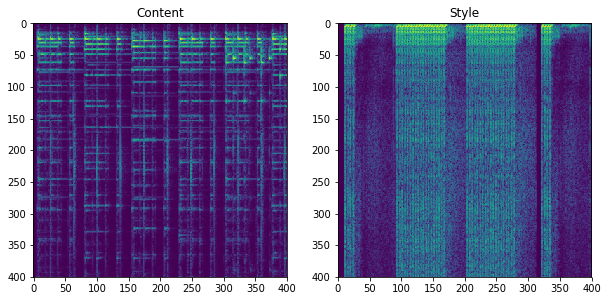

In [10]:
a_content,fs = convert_audio_to_spectogram(CONTENT_FILENAME)
a_style, fs = convert_audio_to_spectogram(STYLE_FILENAME) #rows=(nfft+1)/2, columns=(time_frames - nfft)/(hop_length)+ 5
print("before resizing::", a_style.shape , a_content.shape) 
a_style, a_content = match_shapes(a_content, a_style, N_SAMPLES)
print("after resizing::", a_style.shape , a_content.shape)
N_SAMPLES = a_style.shape[1]
plot_spectogram([{"name":"Content","data": a_content},{"name":"Style","data": a_style}])

## Neural Net 

##################################################
Test # 1
Filter Width:  5
===
content shape (1, 1, 396, 4096)
style shape (4096, 4096)
Started optimization:
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 5052.211914
  Number of iterations: 50
  Number of functions evaluations: 63
i: 0 Interim loss: 5052.212


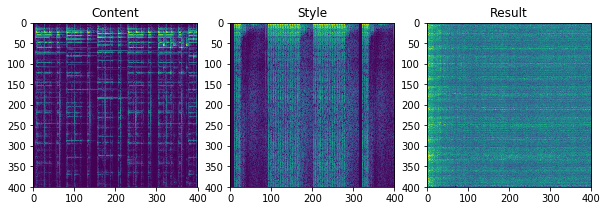

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 4121.340332
  Number of iterations: 50
  Number of functions evaluations: 51
i: 1 Interim loss: 4121.3403


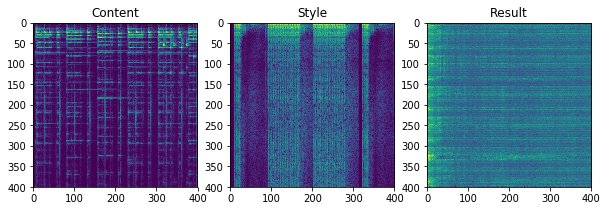

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 3925.040283
  Number of iterations: 50
  Number of functions evaluations: 53
i: 2 Interim loss: 3925.0403


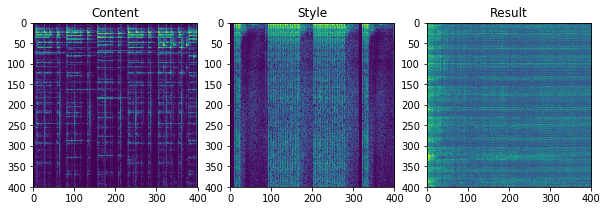

Final loss: 3925.0403
Final result: [[[[-1.5290508e-01 -2.1022910e-01 -4.7097918e-01 ... -1.1822934e-01
     4.6352297e-01  1.1948801e-01]
   [ 3.5259134e-01  8.7614399e-01  2.8048491e-01 ...  1.6797233e-01
     1.1020160e-03 -3.5012296e-01]
   [ 2.0803995e-01  5.3838807e-01  1.4058453e+00 ...  3.2510515e-02
     5.5811763e-01  1.4701392e-01]
   ...
   [ 2.6825273e+00  2.6727602e+00  3.6691353e+00 ...  3.0945888e-01
    -1.5860105e+00 -1.2900551e-01]
   [ 1.4890913e+00  6.7132342e-01  3.3095951e+00 ...  3.6143336e-01
    -5.8813614e-01 -1.4560772e-02]
   [ 1.0583349e+00  4.1824999e-01  3.1946967e+00 ...  8.2528269e-01
    -1.1644305e+00  4.5912042e-01]]]]
##################################################
Test # 2
Filter Width:  10
===
content shape (1, 1, 391, 4096)
style shape (4096, 4096)
Started optimization:
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 5631.664062
  Number of iterations: 50
  Nu

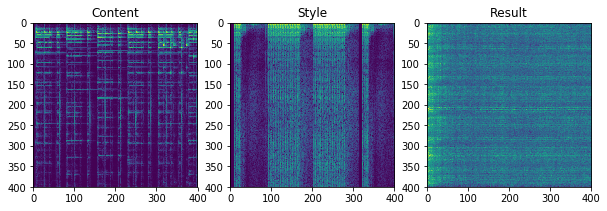

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 4577.109375
  Number of iterations: 50
  Number of functions evaluations: 53
i: 1 Interim loss: 4577.1094


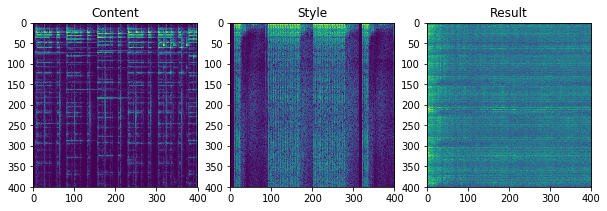

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 4348.403320
  Number of iterations: 50
  Number of functions evaluations: 52
i: 2 Interim loss: 4348.4033


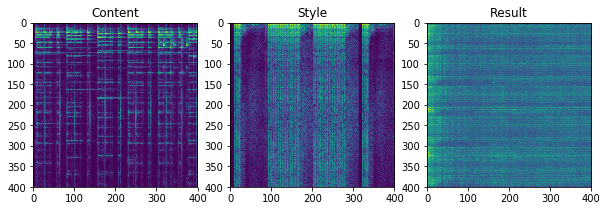

Final loss: 4348.4033
Final result: [[[[ 0.26121518  0.5316413  -0.24418047 ...  0.52532226  0.16443591
    -0.20151158]
   [ 0.20109038 -0.734981   -0.15708375 ... -0.29751202 -0.53527886
     0.64955527]
   [ 0.04954681  0.05928643  0.1547579  ... -0.37562904  0.1700016
     0.7306285 ]
   ...
   [ 1.0421109   0.30526644  1.9121342  ...  0.19844718  0.3413512
     0.20546283]
   [ 1.3998878  -0.36452305  0.07070127 ...  0.2488372   0.1879613
    -0.2741876 ]
   [ 0.56918883 -0.55015594  0.71075654 ... -0.30984026  0.23740925
    -0.66414505]]]]
##################################################
Test # 3
Filter Width:  15
===
content shape (1, 1, 386, 4096)
style shape (4096, 4096)
Started optimization:
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 6093.073242
  Number of iterations: 50
  Number of functions evaluations: 62
i: 0 Interim loss: 6093.073


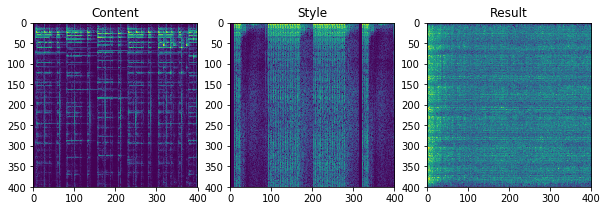

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 4809.466309
  Number of iterations: 50
  Number of functions evaluations: 53
i: 1 Interim loss: 4809.4663


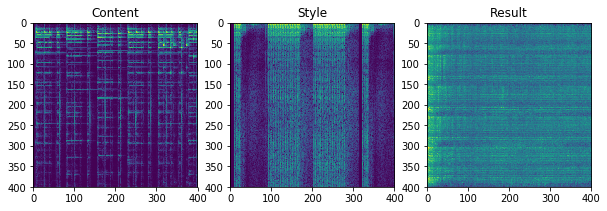

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 4569.061035
  Number of iterations: 50
  Number of functions evaluations: 53
i: 2 Interim loss: 4569.061


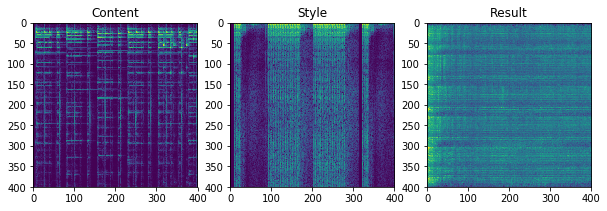

Final loss: 4569.061
Final result: [[[[-0.06273288 -0.38389292 -0.32113013 ... -0.46419916  0.30746475
     0.37425914]
   [ 0.02903934  0.55281574 -0.64959633 ... -0.5813177  -0.31554767
    -0.32624015]
   [-0.61943096 -0.12276807 -0.935332   ... -1.0180233   0.07300545
    -0.09037159]
   ...
   [ 0.6713781  -0.7838744   0.5008458  ...  0.06286576 -0.46440345
    -0.45316276]
   [ 0.815453   -0.16402572  0.9228791  ...  0.33827424  0.04596404
    -0.28785425]
   [ 0.40548384 -0.96844137  1.2784232  ...  0.36646223  0.54589146
    -0.12636012]]]]
##################################################
Test # 4
Filter Width:  20
===
content shape (1, 1, 381, 4096)
style shape (4096, 4096)
Started optimization:
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 5910.385742
  Number of iterations: 50
  Number of functions evaluations: 63
i: 0 Interim loss: 5910.3857


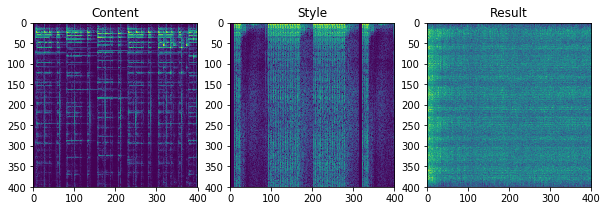

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 4679.952637
  Number of iterations: 50
  Number of functions evaluations: 51
i: 1 Interim loss: 4679.9526


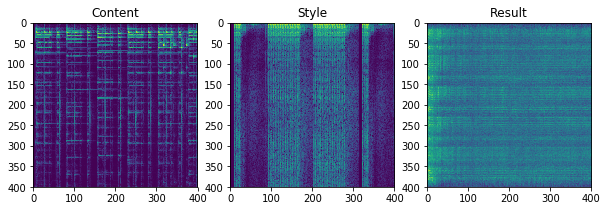

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 4441.409668
  Number of iterations: 50
  Number of functions evaluations: 54
i: 2 Interim loss: 4441.4097


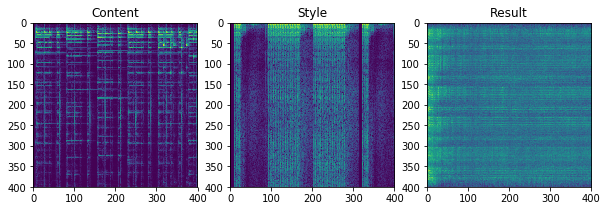

Final loss: 4441.4097
Final result: [[[[ 0.22927618 -0.41832092  0.07451957 ... -0.23632896  0.07684577
    -0.04183373]
   [-0.00398083 -0.09670173 -0.19752453 ... -0.04877836  0.19982098
     0.49219415]
   [ 0.45581573 -0.35883185 -0.09640311 ... -0.24102767 -0.21991752
    -0.80409735]
   ...
   [-0.07205138  0.6271143  -0.21974193 ...  0.14455079  0.505787
     0.6024648 ]
   [-0.01780538  0.0121513  -0.31216696 ...  0.27009368  0.46920383
     0.9429366 ]
   [ 0.447385   -0.16815744 -0.3068396  ...  0.04166304  0.43961594
     0.3669694 ]]]]
##################################################
Test # 5
Filter Width:  25
===
content shape (1, 1, 376, 4096)
style shape (4096, 4096)
Started optimization:
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 6234.753906
  Number of iterations: 50
  Number of functions evaluations: 62
i: 0 Interim loss: 6234.754


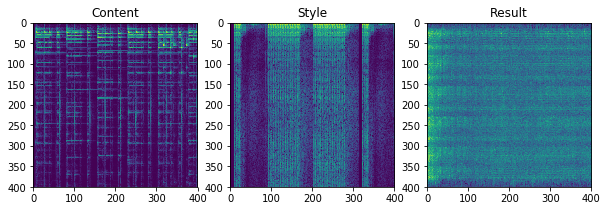

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 4880.126465
  Number of iterations: 50
  Number of functions evaluations: 52
i: 1 Interim loss: 4880.1265


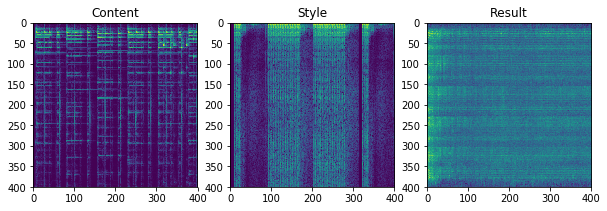

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 4623.708496
  Number of iterations: 50
  Number of functions evaluations: 53
i: 2 Interim loss: 4623.7085


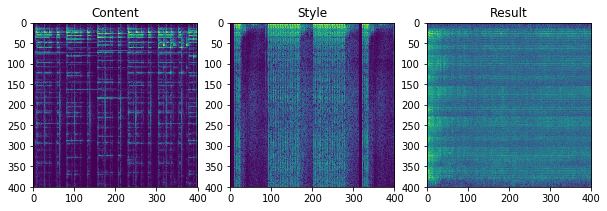

Final loss: 4623.7085
Final result: [[[[-0.16018444  0.29727608 -0.19167066 ...  0.05354245 -0.20100328
    -0.07234889]
   [ 0.94927293 -0.29934022 -0.20099661 ...  0.21176507  0.15337023
    -0.5415795 ]
   [ 0.94286937 -0.29141814  0.1859367  ...  0.20176084  0.68702894
     0.15343973]
   ...
   [ 0.02293449  0.71664596  0.22237633 ... -0.27700695 -1.0725269
    -0.16987859]
   [-0.7584491   0.8529851  -0.1589178  ... -0.6098804  -0.2422535
    -0.7735863 ]
   [ 0.3175531   0.54105467  0.35645    ... -0.83962536 -0.09875438
    -0.6344979 ]]]]
##################################################
Test # 6
Filter Width:  30
===
content shape (1, 1, 371, 4096)
style shape (4096, 4096)
Started optimization:
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 5989.861328
  Number of iterations: 50
  Number of functions evaluations: 63
i: 0 Interim loss: 5989.8613


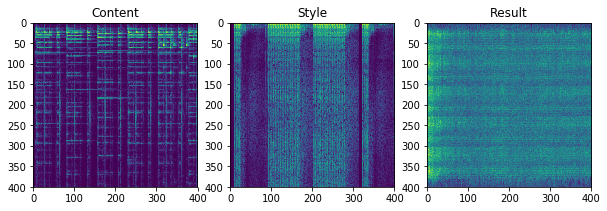

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 4694.294922
  Number of iterations: 50
  Number of functions evaluations: 52
i: 1 Interim loss: 4694.295


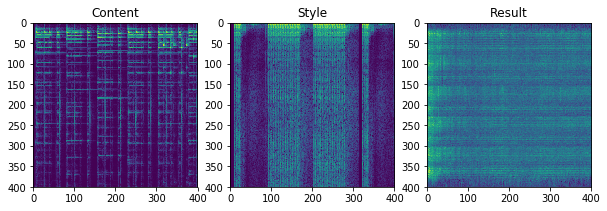

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 4442.309570
  Number of iterations: 50
  Number of functions evaluations: 52
i: 2 Interim loss: 4442.3096


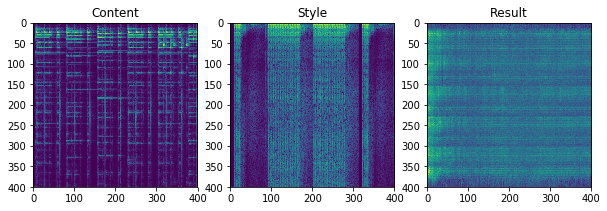

Final loss: 4442.3096
Final result: [[[[ 0.1917235   0.08151467  0.02480552 ... -0.24301039  0.17567988
     0.22582678]
   [-0.34096146  0.25317106 -0.76782507 ... -0.2076378   0.24631393
     0.7950308 ]
   [ 0.24002953  0.1132062  -0.03115163 ... -0.88617235 -0.25567612
     0.78085   ]
   ...
   [ 1.0279872   0.2698335   1.0711992  ... -0.20630614 -0.3275735
    -0.1382864 ]
   [ 0.45231366 -0.16636917  0.63216394 ... -0.13744877 -0.14096001
     0.56067187]
   [ 0.12270298 -0.29018295 -0.32138467 ...  0.03660402 -0.24118307
     0.19168712]]]]


In [11]:
for i, FILTER_WIDTH in enumerate(FILTER_WIDTH_LIST):
    print("##################################################")
    print("Test #", i+1)
    print("Filter Width: ", FILTER_WIDTH)
    print("===")
    a_content_tf = np.ascontiguousarray(a_content.T[None,None,:,:])#1x1x1025x400
    a_style_tf = np.ascontiguousarray(a_style.T[None,None,:,:])

    # filter shape is [filter_height, filter_width, in_channels, out_channels]
    std = np.sqrt(2) * np.sqrt(2.0 / ((N_CHANNELS + N_FILTERS) * FILTER_WIDTH))
    filterr = np.random.randn(1, FILTER_WIDTH, N_CHANNELS, N_FILTERS)*std

    g = tf.Graph()
    with g.as_default(), g.device('/cpu:0'), tf.Session() as sess:

        filter_tf = tf.constant(filterr, name="filter", dtype='float32')

        # data shape is "[batch, in_height, in_width, in_channels]",
        x_CS = tf.placeholder('float32', [1,1,N_SAMPLES,N_CHANNELS], name="x_CS")
        conv_CS = tf.nn.conv2d(x_CS,filter_tf,strides=[1, 1, 1, 1],padding="VALID",name="conv_CS")
        net_CS = tf.nn.relu(conv_CS)

        #extracting content
        content_features = net_CS.eval(feed_dict={x_CS: a_content_tf})
        print('content shape', content_features.shape)

        #extracting style
        style_features = net_CS.eval(feed_dict={x_CS: a_style_tf})
        features = np.reshape(style_features, (-1, N_FILTERS))
        style_gram = np.matmul(features.T, features) / N_SAMPLES
        print('style shape', style_gram.shape)

    with tf.Graph().as_default():
        filter_tf = tf.constant(filterr, name="filter", dtype='float32')

        # variable input
        x = tf.Variable(np.random.randn(1,1,N_SAMPLES,N_CHANNELS).astype(np.float32)*1e-3, name="x")
        conv = tf.nn.conv2d(x,filter_tf,strides=[1, 1, 1, 1],padding="VALID",name="conv")
        net = tf.nn.relu(conv)

        #optimize
        result = None
        interim_result = None

        ##content loss
        content_loss = 2 * tf.nn.l2_loss(net - content_features)

        ##style loss
        _, height, width, number = map(lambda i: i.value, net.get_shape())
        size = height * width * number
        feats = tf.reshape(net, (-1, number))
        gram = tf.matmul(tf.transpose(feats), feats)  / N_SAMPLES
        style_loss = 2 * tf.nn.l2_loss(gram - style_gram)

        ## Overall loss
        loss = ALPHA*content_loss + BETA*style_loss

        ##Optimization   
        opt = tf.contrib.opt.ScipyOptimizerInterface(loss, method='L-BFGS-B', options={'maxiter': iterations})    
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            print('Started optimization:')
            for i in range(EPOCHS):
                opt.minimize(sess)
                print('i:' , i , 'Interim loss:', loss.eval())
                interim_result = x.eval()
                step_handler_callback(interim_result, i)

        ## result
            print ('Final loss:', loss.eval())
            result = x.eval()
            print('Final result:', result)
            
            TESTRESULTS.append(loss.eval())

## Comparison Plot - Filter Width

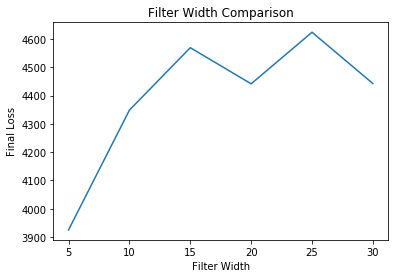

In [13]:
x = FILTER_WIDTH_LIST
y = TESTRESULTS

plt.plot(x, y)
plt.title("Filter Width Comparison")
plt.xlabel("Filter Width")
plt.ylabel("Final Loss")
plt.show()

## Invert spectrogram and save the result

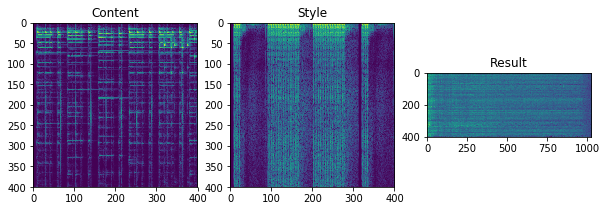

In [19]:
step_handler_callback(result, 47, output_path = OUTPUT_FILENAME)